<a href="https://colab.research.google.com/github/seoes/exhibition-visitor-tracker/blob/main/2-filter-ids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')
result_dir_path = "/content/drive/MyDrive/results"

result_path = "/content/drive/MyDrive/result"
filename = "exhibition-64-full.mp4"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 로컬 환경에서 연결

In [ ]:
import os
HOME = os.getcwd()
%cd {HOME}

filename = ""

with open(f"{HOME}/filename.txt", 'r') as file:
    for line in file:
        filename = line.strip()

result_path = f"{HOME}/result"

# 총 이동거리 계산 / 총 이동거리 분포 출력

{1: 1989.9026280013638, 2: 416.24274207474656, 3: 333.7371894944105, 4: 1566.6507184580505, 5: 246.50361759857088, 6: 140.48006362227503, 7: 13719.4175698849, 8: 342.6268802917389, 9: 864.7514383321343, 10: 692.8399835435423, 11: 3635.2825096084707, 12: 1409.8191913651117, 13: 737.2228380551119, 14: 1550.6653688933454, 15: 1782.8942577461635, 16: 10.318830507798008, 17: 1636.7892576785246, 18: 1294.5790885509498, 20: 995.2731704599414, 22: 36.05055226395664, 23: 1936.6644085412825, 24: 34.52926092857571, 25: 113.32784938988013, 26: 172.94288384284647, 27: 3721.8652930361445, 28: 3909.8535321223653, 29: 690.2647424662852, 30: 314.2982461728453, 31: 874.0150546526295, 33: 1188.368955524723, 34: 82.90368034025077, 35: 1378.0726677255902, 39: 280.3680329888675, 41: 33.60181429023674, 42: 45.640986324787455, 43: 1079.4908659405198, 44: 2223.901140815645, 45: 135.45835535638588, 46: 526.4948303037739, 47: 49.99070478491457, 48: 1034.0243304443536, 50: 40.1890126382597, 51: 84.39142635809449,

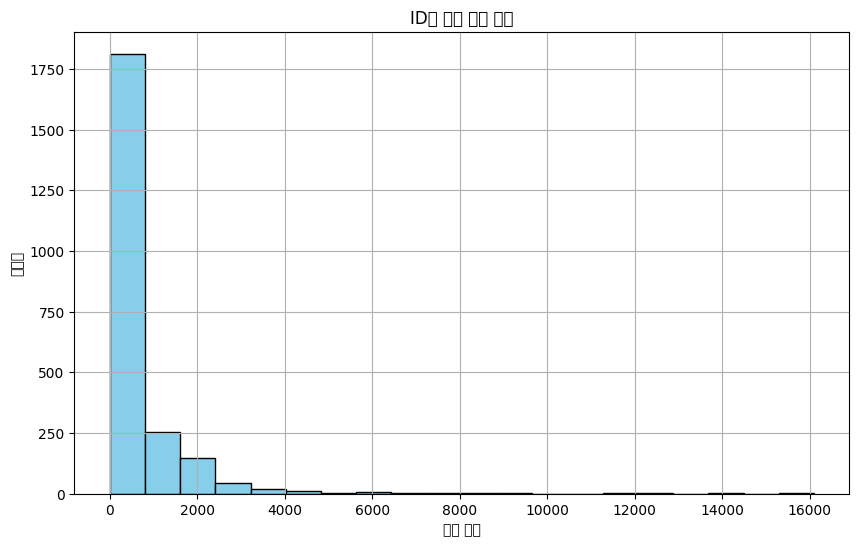

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def parse_data(file_path):
    data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip():  # Ignore empty lines
                frame, id, conf, x, y = line.strip().split(', ')
                frame, id, x, y = map(int, [frame, id, x, y])
                if id not in data:
                    data[id] = []
                data[id].append((x, y))
    return data


def calculate_distances(data):
    distances = {}
    for id, points in data.items():
        total_distance = 0
        for i in range(1, len(points)):
            prev_point = points[i - 1]
            current_point = points[i]
            distance = np.sqrt((current_point[0] - prev_point[0])**2 + (current_point[1] - prev_point[1])**2)
            total_distance += distance
        distances[id] = total_distance
    return distances



data = parse_data(f"{result_path}/{filename}-1-each_coord.txt")
distances = calculate_distances(data)

print(distances)

distances_array = np.array(list(distances.values()))
print("ID별 이동 거리:", distances_array)

plt.figure(figsize=(10, 6))
plt.hist(distances_array, bins=20, color='skyblue', edgecolor='black')
plt.title('ID별 이동 거리 분포')
plt.xlabel('이동 거리')
plt.ylabel('빈도수')
plt.grid(True)
plt.show()


## 클러스터 계산

가장 적절한 클러스터링 결과 도출을 위해, 가장 이상적인 클러스터 개수 찾기

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

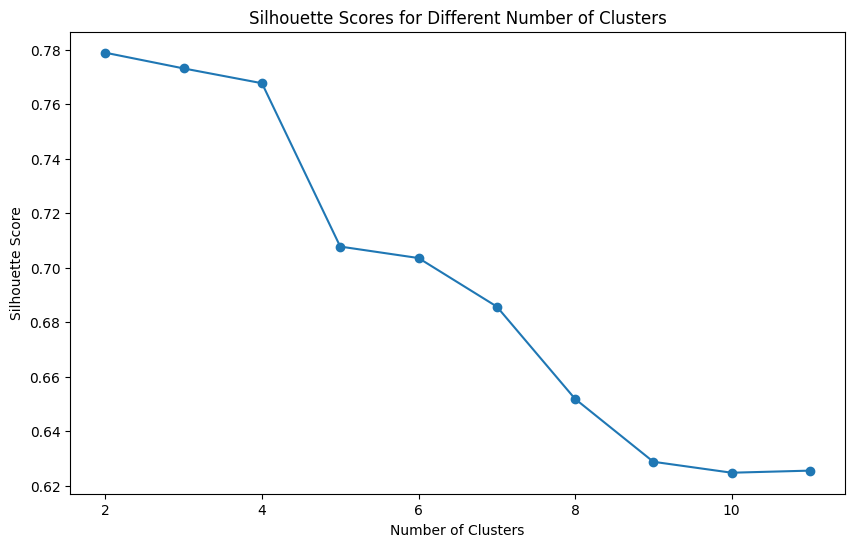

Maximum Silhouette Score: 0.7788266355576422
Optimal Number of Clusters: 2


In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

ids = np.array(list(distances.keys())).reshape(-1, 1)
distance_values = np.array(list(distances.values())).reshape(-1, 1)

def calculate_silhouette_scores(data, cluster_range):
    silhouette_scores = []
    for n_clusters in cluster_range:
        model = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
        labels = model.labels_
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    return silhouette_scores

cluster_range = range(2, 12)  # 2개부터 12개 사이에서 클러스터 수 찾도록 제한걸기
silhouette_scores = calculate_silhouette_scores(distance_values, cluster_range)


max_score_index = np.argmax(silhouette_scores) # 클러스터 개수 중에서 score가 가장 높은 것 찾기
max_cluster = cluster_range[max_score_index]
max_score = silhouette_scores[max_score_index]

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

print("Maximum Silhouette Score:", max_score)
print("Optimal Number of Clusters:", max_cluster)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


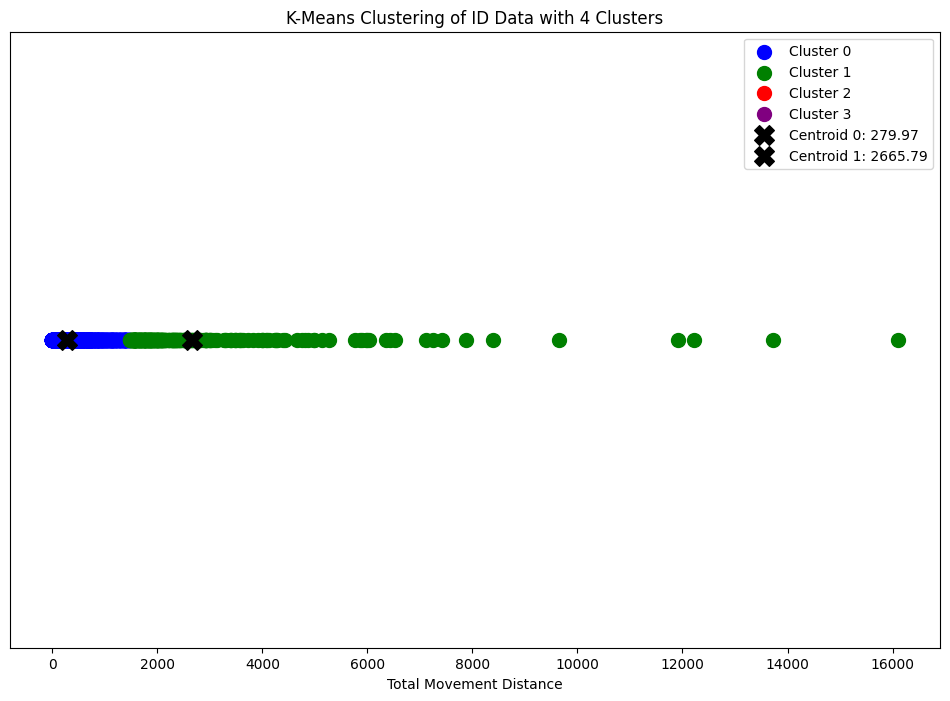

[   1    4    7   11   14   15   17   23   27   28   44   57   83   89
  105  113  118  151  180  192  199  202  212  221  225  241  254  265
  288  306  307  323  328  352  366  368  393  412  421  425  428  436
  449  480  487  505  518  529  547  560  568  576  580  588  592  595
  622  628  636  639  640  644  646  691  712  735  748  769  780  792
  797  798  808  809  810  814  834  842  849  864  870  874  875  880
  881  903  907  911  916  927  942  964  980  987  991  994 1027 1031
 1042 1063 1067 1074 1085 1092 1105 1109 1126 1149 1151 1152 1171 1188
 1189 1219 1241 1246 1255 1257 1267 1279 1287 1296 1324 1325 1342 1346
 1356 1360 1378 1397 1400 1413 1425 1440 1447 1461 1464 1465 1467 1470
 1484 1491 1496 1499 1516 1517 1519 1521 1534 1546 1547 1565 1570 1596
 1619 1624 1629 1630 1643 1683 1714 1719 1724 1736 1762 1767 1773 1779
 1791 1832 1833 1848 1869 1887 1893 1943 1948 1985 1986 1988 1997 2000
 2009 2011 2025 2028 2034 2043 2053 2070 2090 2104 2107 2132 2151 2182
 2184 

In [36]:
def perform_clustering_with_4_clusters(data):
    kmeans_model = KMeans(n_clusters=max_cluster, random_state=0).fit(data)
    labels = kmeans_model.labels_
    centroids = kmeans_model.cluster_centers_

    # 거리가 가장 작은 클러스터 찾기
    centroid_distances = kmeans.transform(distance_values).mean(axis=0)
    closest_cluster = np.argmin(centroid_distances)

    # 거리가 가장 작은 클러스터를 제외한 나머지 클러스터에 속한 ID 추출
    selected_ids = ids[labels != closest_cluster].flatten()

    # Visualization
    plt.figure(figsize=(12, 8))
    colors = ['blue', 'green', 'red', 'purple']
    for i in range(4):
        plt.scatter(data[labels == i, 0], np.zeros(len(data[labels == i])), color=colors[i], s=100, label=f'Cluster {i}')
    for i, centroid in enumerate(centroids):
        plt.scatter(centroid, 0, color='black', marker='X', s=200, label=f'Centroid {i}: {centroid[0]:.2f}')

    plt.title('K-Means Clustering of ID Data with 4 Clusters')
    plt.xlabel('Total Movement Distance')
    plt.yticks([])  # Disabling Y-axis labels
    plt.legend()
    plt.show()
    return selected_ids

# Performing clustering with 4 clusters
distances_array = distances_array.reshape(-1, 1)
selected_ids = perform_clustering_with_4_clusters(distances_array)
print(selected_ids)

# 남은 ID값 저장

In [49]:

with open(f"{result_path}/{filename}-2-selected_ids", "w") as file:
    for id in selected_ids:
        file.write(f"{id}\n")

# 선택된 ID로 필터링


In [50]:
selected_ids = list()

with open(f"{result_path}/{filename}-2-selected_ids", "r") as file:
    for line in file:
       selected_ids.append(int(line.strip()))

loaded_nested_data = list()
temp_array = list()

with open(f"{result_path}/{filename}-1-each_coord.txt", 'r') as f:
    for line in f:
        if line.strip():  # 빈 줄이 아니면
            tuple_elements = line.strip().split(', ')
            temp_list = list(map(lambda x: int(x) if x.isdigit() else x, tuple_elements))
            temp_list[2] = float(temp_list[2])
            temp_tuple = tuple(temp_list)
            if temp_tuple[1] in selected_ids:
                temp_array.append(temp_tuple)
        else:  # 빈 줄이면 현재까지의 temp_array를 loaded_nested_data에 추가하고 temp_array 초기화
            loaded_nested_data.append(temp_array)
            temp_array = []
    if temp_array:  # 파일의 마지막에 빈 줄이 없는 경우 처리
        loaded_nested_data.append(temp_array)

with open(f'{result_path}/{filename}-3-filtered_coord.txt', 'w') as f:
    for coords in loaded_nested_data:
        for tuple_ in coords:
            line = ', '.join(map(str, tuple_))  # 튜플의 각 요소를 문자열로 변환하고 쉼표로 구분
            f.write(line + '\n')  # 파일에 한 줄씩 쓰기
        f.write('\n')  # 배열 각각을 구분하기 위해 빈 줄 추가